In [1]:
%cd ..

/home/cole/Documents/dl-final-project


In [2]:
import torch
import random
import numpy as np
from data import get_unlabeled_set, set_seeds
from model.resnet import Prototype

random.seed(42)
np.random.seed(42)
torch.manual_seed(42);

In [3]:
batch_size = 3

if torch.cuda.is_available():
    batch_size *= torch.cuda.device_count()

unlabeled_trainset, unlabeled_trainloader = get_unlabeled_set(batch_size=batch_size)

In [4]:
# sample, target, road_image, extra = iter(labeled_trainloader).next()
# print(torch.stack(sample).shape)

image, camera_index = iter(unlabeled_trainloader).next()
print(image.shape)

torch.Size([3, 3, 256, 306])


In [5]:
from data import get_labeled_set
labeled_trainset, labeled_trainloader = get_labeled_set(batch_size=3)
sample, target, road_image = iter(labeled_trainloader).next()

In [6]:

print(torch.stack(sample).shape)
print(target[0]['bounding_box'][0])
print(target[0]['bounding_box'][0].T)

torch.Size([3, 6, 3, 256, 306])
tensor([[-3.1910, -3.1782, -7.5669, -7.5541],
        [ 4.4740,  2.6886,  4.4425,  2.6571]], dtype=torch.float64)
tensor([[-3.1910,  4.4740],
        [-3.1782,  2.6886],
        [-7.5669,  4.4425],
        [-7.5541,  2.6571]], dtype=torch.float64)


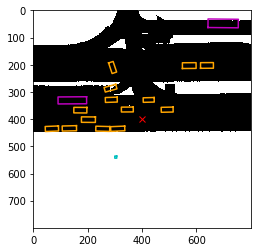

In [7]:
import matplotlib.pyplot as plt
from helpers.helper import draw_box
# The center of image is 400 * 400
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])

In [11]:
from data import make_bounding_box_images

target_images = make_bounding_box_images(target)
target_images.shape

torch.Size([3, 10, 800, 800])

In [14]:
x = target_images[0]
x[0].shape

torch.Size([800, 800])

torch.Size([800, 800])


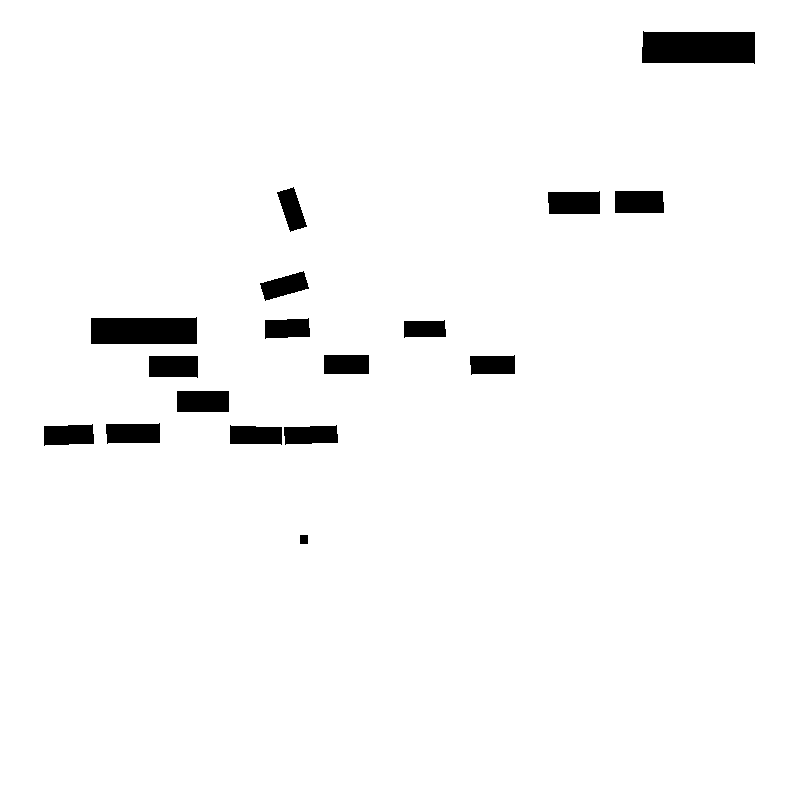

In [10]:
from PIL import Image, ImageDraw

mask = target_images[0][[0][0]]
print(mask.shape)
Image.fromarray(mask.numpy().astype('bool')).convert('1')

In [47]:
boxes = []
categories = []

# Iterate over batch
t = target[0]
bboxes = t['bounding_box']
cat = t['category']
    
# Iterate over boxes
for i in range(len(bboxes)):
    b = bboxes[i]
    b = b.T * 10
    b[:,1] *= -1
    b += + 400
    b = [tuple(x) for x in b.numpy()]
    b[-2], b[-1] = b[-1], b[-2]
    c = cat[i].item() + 1
    boxes.append(b)
    categories.append(c)

In [80]:
from PIL import Image, ImageDraw, ImageFont


channels = []
for c in range(1, 10):
    canvas = Image.new('1', (800, 800))
    context = ImageDraw.Draw(canvas)
    boxes_idx = [i for i in range(len(categories)) if categories[i] == c]
    for i in boxes_idx:
        context.polygon(boxes[i], fill=1)
    channels.append(np.array(canvas).astype(float))

In [81]:
mask = np.logical_not(sum(np.array(channels))).astype(float)

In [82]:
mask

# canvas = Image.new('1', (800, 800))
# drawing_context = ImageDraw.Draw(canvas)
# y1, x1 = 34 *10 + 400, 9 *10 + 400
# x2, y2 = 29*10 + 400, 7 *10 + 400


# drawing_context.rectangle([x1, y1, x2, y2], fill=1)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

# Model

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
device

device(type='cpu')

### Hyperparameters

In [26]:
epochs = 1
hidden_size = 1024

model = Prototype(hidden_dim=hidden_size)

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model)
    assert batch_size >= torch.cuda.device_count()

model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters())

In [17]:
model.train()

for epoch in range(epochs):
    loss = 0.0
    
    max_batches = len(unlabeled_trainloader)
    for idx, (images, camera_index) in enumerate(unlabeled_trainloader):
        optimizer.zero_grad()
        
        images = images.to(device)
        reconstructions = model(images)
        loss = criterion(reconstructions, images)
        
        loss.backward()
        optimizer.step()
        
        if idx % 1000 == 0:
            print('[', epoch, '|', idx ,'/', max_batches, ']', 'loss:', loss.item())

[ 0 | 0 / 26712 ] loss: 0.5756482481956482
[ 0 | 1 / 26712 ] loss: 0.652309000492096
[ 0 | 2 / 26712 ] loss: 0.5202575922012329
[ 0 | 3 / 26712 ] loss: 0.6401046514511108
[ 0 | 4 / 26712 ] loss: 0.645193338394165
[ 0 | 5 / 26712 ] loss: 0.6373991966247559
[ 0 | 6 / 26712 ] loss: 0.6325534582138062
[ 0 | 7 / 26712 ] loss: 0.5634716153144836
[ 0 | 8 / 26712 ] loss: 0.604899525642395
[ 0 | 9 / 26712 ] loss: 0.6308258175849915
[ 0 | 10 / 26712 ] loss: 0.6094906330108643
[ 0 | 11 / 26712 ] loss: 0.6008045673370361
[ 0 | 12 / 26712 ] loss: 0.5547239184379578
[ 0 | 13 / 26712 ] loss: 0.6735868453979492
[ 0 | 14 / 26712 ] loss: 0.5667365789413452
[ 0 | 15 / 26712 ] loss: 0.5744085907936096
[ 0 | 16 / 26712 ] loss: 0.5768027305603027
[ 0 | 17 / 26712 ] loss: 0.5797910094261169
[ 0 | 18 / 26712 ] loss: 0.6291548013687134
[ 0 | 19 / 26712 ] loss: 0.5445032715797424
[ 0 | 20 / 26712 ] loss: 0.542401909828186
[ 0 | 21 / 26712 ] loss: 0.6173267960548401
[ 0 | 22 / 26712 ] loss: 0.6424456834793091
[ 

KeyboardInterrupt: 